## Content

* did data visulizations specific to one company (Apple)
    * could further compare within the company: iphone vs ipad?
    * could extend to specific industries later
* did a simple regression using XGboost
    * need to tune hyperparameters later
    * need to deal with similar issues as those in classification (e.g. imbalanced data, dependencies?)
    * could combine regression results with the std measuring metrics to get market events

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load event data

In [5]:
# load Gdelt data from 2007-01-01 to 2017-10-06
# Credit to Michael Di Amore
load_data = True
if load_data == True:
    #print ('Loading Data...')
    df_early = pd.read_csv('Gdelt_events_20070101_20131231.csv')
    df_early = df_early.set_index('sqldate',drop=True).sort_index()
    df_2014_01 = pd.read_csv('Gdelt_events_20140101_20140531.csv')
    df_2014_01  = df_2014_01 .set_index('sqldate',drop=True).sort_index()
    
    df_2014_02 = pd.read_csv('Gdelt_events_20140601_20141231.csv')
    df_2014_02  = df_2014_02 .set_index('sqldate',drop=True).sort_index()
    
    df1 = pd.read_csv('Gdelt_events_20150101_20151231.csv')
    df1 = df1.set_index('sqldate',drop=True).sort_index()
    df2 = pd.read_csv('Gdelt_events_20160101_20171006.csv')
    df2 = df2.set_index('sqldate',drop=True).sort_index()
    gdelt_df = pd.concat([df_early,df_2014_01,df_2014_02,df1,df2])
    
    del df_early,df_2014_01,df_2014_02,df1,df2

In [6]:
# Item counts in each year
from collections import Counter
Counter(gdelt_df.index.values//10000)

Counter({2007: 111821,
         2008: 165655,
         2009: 242623,
         2010: 314675,
         2011: 468098,
         2012: 508527,
         2013: 487334,
         2014: 641748,
         2015: 843699,
         2016: 913927,
         2017: 647581})

In [7]:
# convert index from int to date
gdelt_df.index = gdelt_df.index.astype(str)
gdelt_df.index = pd.to_datetime(gdelt_df.index)

## Visualization

### Apple-related events

There are 15481 headlines containing 'apple'.


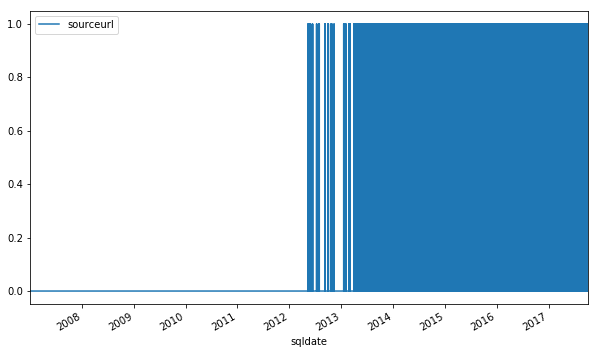

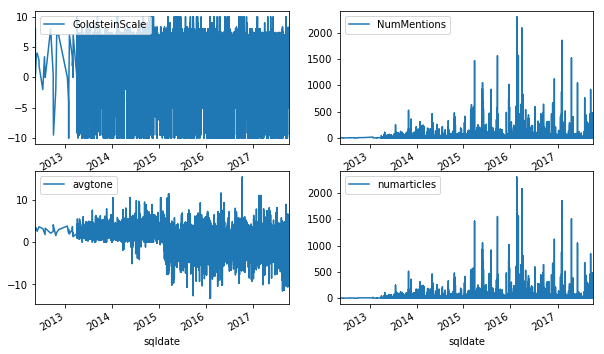

In [12]:
def str_match(a):
    if a.find("apple") == -1:
        return 0
    else:
        return 1
result = gdelt_df['sourceurl'].apply(str_match)
print("There are "+ str(sum(result))+" headlines containing 'apple'.")

plt.rcParams['figure.figsize'] = (10, 6)

plt.figure()
result.plot()
plt.legend()

index = np.where(result==1)
apple_df = gdelt_df.iloc[list(index[0])]
plt.figure()
plt.subplot(221)
apple_df['GoldsteinScale'].plot()
plt.legend()

plt.subplot(222)
apple_df['NumMentions'].plot()
plt.legend()

plt.subplot(223)
apple_df['avgtone'].plot()
plt.legend()

plt.subplot(224)
apple_df['numarticles'].plot()
plt.legend()
plt.show()

Events related to "apple" all take place after year 2012.

### Explore extreme values

In [65]:
# find extreme "avgtone"
idx1 = np.where(apple_df['avgtone'] >= 10)[0]
idx2 = np.where(apple_df['avgtone'] <= -10)[0]
idx = np.append(idx1, idx2)
apple_df.index[idx]

DatetimeIndex(['2014-01-08', '2014-05-20', '2015-01-13', '2015-01-13',
               '2015-01-13', '2015-01-13', '2015-03-04', '2015-03-16',
               '2015-03-16', '2016-04-26', '2016-04-26', '2016-10-08',
               '2017-02-15', '2017-03-03', '2015-04-09', '2015-04-09',
               '2015-08-07', '2015-08-07', '2015-09-23', '2015-09-23',
               '2015-12-02', '2016-02-03', '2016-02-03', '2016-02-03',
               '2016-03-31', '2016-05-06', '2016-05-06', '2017-03-19',
               '2017-08-17', '2017-08-30', '2017-08-30', '2017-09-14',
               '2017-09-27'],
              dtype='datetime64[ns]', name='sqldate', freq=None)

### Iphone-related vs Ipad-related events

There are 3672 headlines containing 'iphone'.
There are 781 headlines containing 'ipad'.


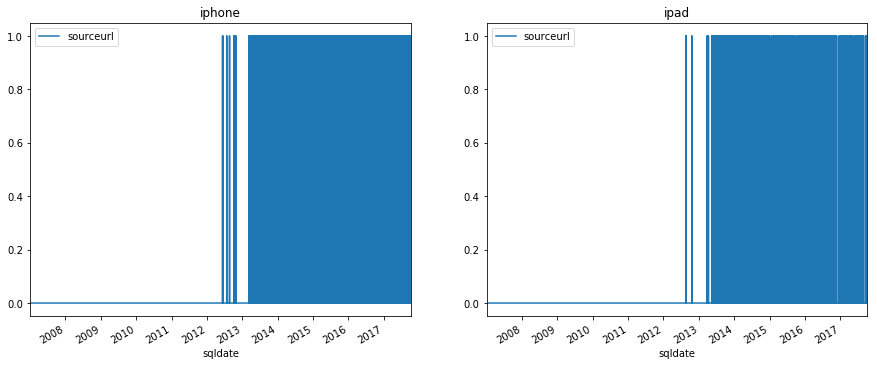

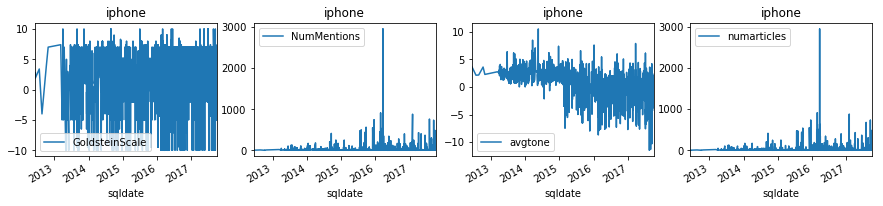

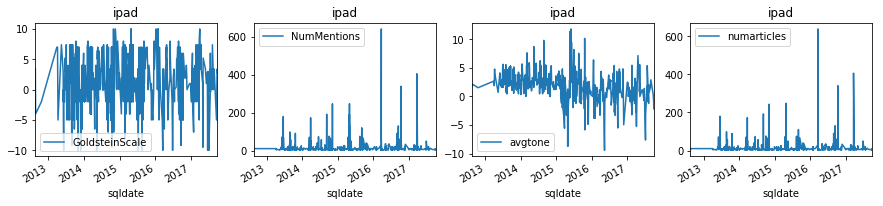

In [13]:
def str_match1(a):
    if a.find("iphone") == -1:
        return 0
    else:
        return 1
result1 = gdelt_df['sourceurl'].apply(str_match1)
print("There are "+ str(sum(result1))+" headlines containing 'iphone'.")


def str_match2(a):
    if a.find("ipad") == -1:
        return 0
    else:
        return 1
result2 = gdelt_df['sourceurl'].apply(str_match2)
print("There are "+ str(sum(result2))+" headlines containing 'ipad'.")


plt.rcParams['figure.figsize'] = (15, 6)

plt.figure()
plt.subplot(121)
result1.plot()
plt.legend()
plt.title("iphone")
index1 = np.where(result1==1)
iphone_df = gdelt_df.iloc[list(index1[0])]

plt.subplot(122)
result2.plot()
plt.legend()
plt.title("ipad")
index2 = np.where(result2==1)
ipad_df = gdelt_df.iloc[list(index2[0])]
plt.show()

plt.figure()
plt.subplot(241)
iphone_df['GoldsteinScale'].plot()
plt.title("iphone")
plt.legend()

plt.subplot(242)
iphone_df['NumMentions'].plot()
plt.title("iphone")
plt.legend()

plt.subplot(243)
iphone_df['avgtone'].plot()
plt.title("iphone")
plt.legend()

plt.subplot(244)
iphone_df['numarticles'].plot()
plt.title("iphone")
plt.legend()


plt.figure()
plt.subplot(245)
ipad_df['GoldsteinScale'].plot()
plt.title("ipad")
plt.legend()

plt.subplot(246)
ipad_df['NumMentions'].plot()
plt.title("ipad")
plt.legend()

plt.subplot(247)
ipad_df['avgtone'].plot()
plt.title("ipad")
plt.legend()

plt.subplot(248)
ipad_df['numarticles'].plot()
plt.title("ipad")
plt.legend()
plt.show()

Obviously, 'iphone' occurs more often than 'ipad'. And "ipad"'s extreme values seems to happen near the dates of "iphone"'s.

### Samsung-related events

There are 2628 headlines containing 'samsung'.


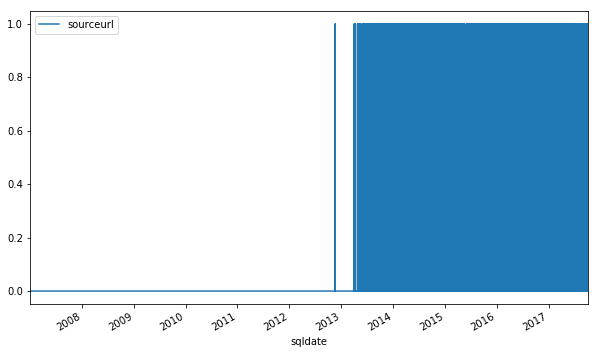

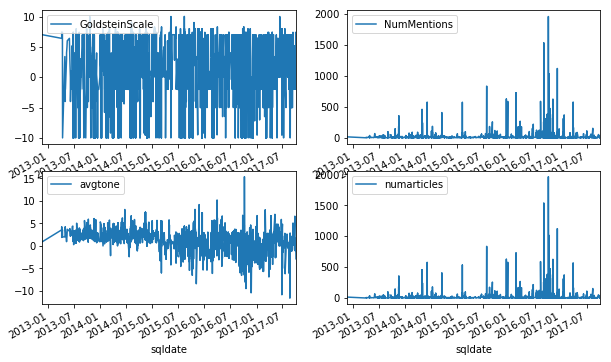

In [64]:
def str_match(a):
    if a.find("samsung") == -1:
        return 0
    else:
        return 1
result = gdelt_df['sourceurl'].apply(str_match)
print("There are "+ str(sum(result))+" headlines containing 'samsung'.")
plt.rcParams['figure.figsize'] = (10, 6)

plt.figure()
result.plot()
plt.legend()

index = np.where(result==1)
samsung_df = gdelt_df.iloc[list(index[0])]

plt.figure()
plt.subplot(221)
samsung_df['GoldsteinScale'].plot()
plt.legend()

plt.subplot(222)
samsung_df['NumMentions'].plot()
plt.legend()

plt.subplot(223)
samsung_df['avgtone'].plot()
plt.legend()

plt.subplot(224)
samsung_df['numarticles'].plot()
plt.legend()
plt.show()

Could explore further with competitor company.

## Load Apple stock price data

In [14]:
# Load apple stock price data from 2007-01-01 to 2017-10-06
AAPL = pd.read_csv('AAPL.csv')
AAPL_df = AAPL.set_index('Date')

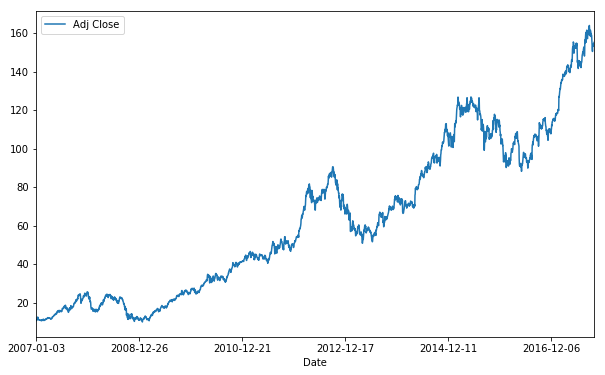

In [16]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.figure()
AAPL_df['Adj Close'].plot()
plt.legend()

### AAPL's volatility

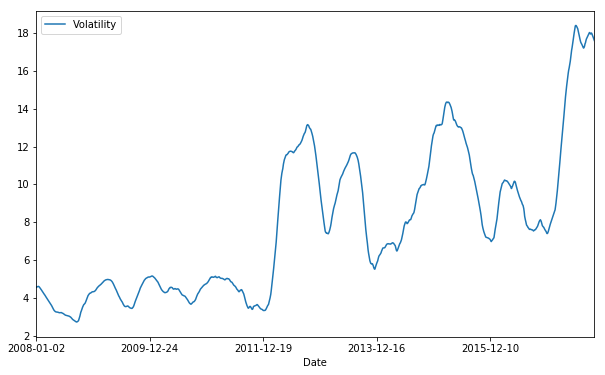

In [17]:
adj_close = AAPL_df['Adj Close']
vol = adj_close.rolling(window = 252).std().dropna()
vol.name = "Volatility"
plt.figure()
vol.plot()
plt.legend()

## Regression Attempt

Using numerical data to predict stock price

In [18]:
df = gdelt_df.drop(['Actor1Name','Actor2Name','sourceurl'], axis=1)
df_new = df.groupby(df.index).mean()
AAPL_df.index = pd.to_datetime(AAPL_df.index)
data = pd.concat([df_new, AAPL_df['Adj Close']], axis=1)
data = data.fillna(method='ffill')
# Delete the first rwo due to NA
data = data[1:]

In [60]:
# split data into X and y
dataset = np.array(data)
X = dataset[:,0:5]
Y = dataset[:,-1]
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
xgb_model = xgb.XGBRegressor().fit(X_train, y_train)
# make predictions for test data
y_pred = xgb_model.predict(X_test)
# MSE
mean_squared_error(y_pred, y_test)

233.22666536999623

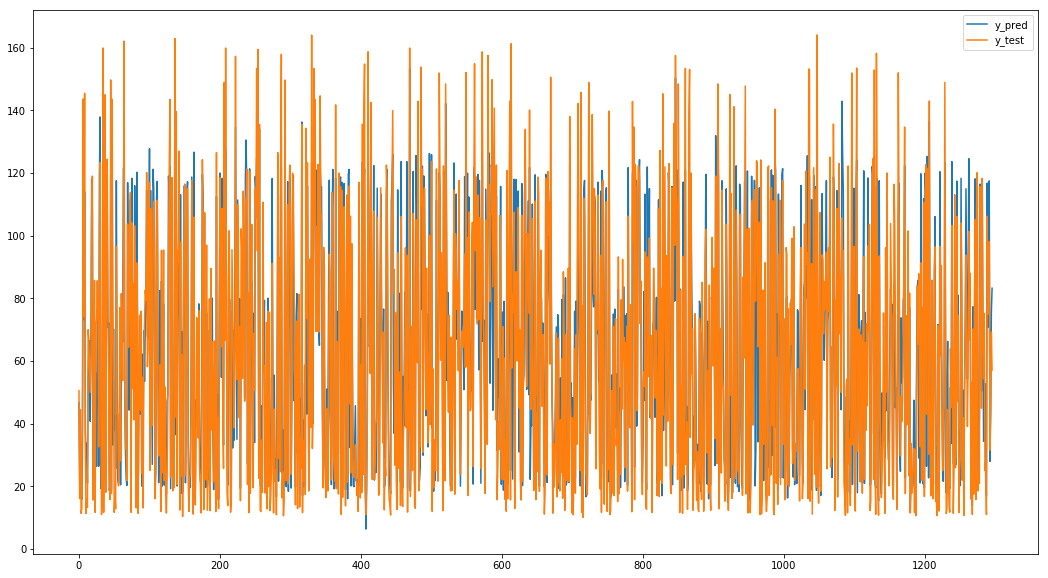

In [77]:
plt.rcParams['figure.figsize'] = (18, 10)
plt.figure()
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(["y_pred","y_test"])
plt.show()